In [1]:
import pandas as pd
import json
import os
import uuid

import geopandas as gpd

In [2]:
with open('../.foursquare_API.json', 'r') as file:
    secrets = json.load(file)

secrets

{'token': 'fsq3D/VHyHU4HVfbaRITsOl0pIswAP2pr//Ac/m+gD5H1TI=',
 'client_id': 'Q1B4DZHK1Q4YYMMQXYH1J4N3CKDH5DLR5FGNTHILBZD0BXVO',
 'client_secret': 'AJWWWAR2WHOQDLLESW4DHRQTXUFEPBOILFHR5XJSATEQZR5D'}

1. Read dataset

In [3]:
dirName = '/Users/mikhailgasanov/Downloads/EVdatasets/PaloAlto/'
fnames = os.listdir(dirName)
df = pd.read_csv(os.path.join(dirName, fnames[0]))

In [4]:
coords = df[['Latitude', 'Longitude']].drop_duplicates()

In [20]:
# LIMIT = 49
# RADIUS = 1000

# Latitude = coords.iloc[0, :]['Latitude']

# Longitude = coords.iloc[0, :]['Longitude']

# session_token = str(uuid.uuid4())

# url = f"https://api.foursquare.com/v3/places/search?ll={Latitude},{Longitude}&radius={RADIUS}&limit={LIMIT}&session_token={session_token}"

# headers = {

#     "Accept": "application/json",

#     "Authorization": secrets['token']

# }

# response = requests.get(url, headers=headers)



In [ ]:
results = response.json()

In [ ]:
import pandas as pd # for data processing
import folium   #for creating maps
import requests  #for retreiving Information from URL
from geopy.geocoders import Nominatim  #converting address to cordinates
from pandas.io.json import json_normalize #converting json to DataFrame 

In [6]:
def getCategory(resp:dict):
    categories = [i['categories'][0]['name'] for i in results['results']]
    latitude = [i['geocodes']['main']['latitude'] for i in results['results']]
    longitude = [i['geocodes']['main']['longitude'] for i in results['results']]
    df = pd.DataFrame(data=[categories, latitude, longitude]).T
    df.columns=['category_building', 'latitude', 'longitude']
    return df

# def getDistance(source_point:dict)

In [7]:
from shapely.geometry import Point

In [8]:
import geopy.distance

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.geodesic(coords_1, coords_2).m)


279352.90160430095


In [9]:
df_cat = getCategory(resp=results)

NameError: name 'results' is not defined

In [10]:
df_cat

NameError: name 'df_cat' is not defined

In [11]:
def getDistance(coords_1:set, coords_2:set):
    return geopy.distance.geodesic(coords_1, coords_2).m

In [12]:
df_cat.loc[:, 'distance'] = df_cat.apply(lambda x: getDistance(coords_1=(Latitude, Longitude), coords_2=(x.latitude, x.longitude)), axis=1)

NameError: name 'df_cat' is not defined

In [13]:
gdf = gpd.GeoDataFrame(data=df_cat, geometry=gpd.points_from_xy(x=df_cat['latitude'], y=df_cat['longitude']))

NameError: name 'df_cat' is not defined

In [14]:
import plotly.graph_objects as go
import pandas as pd


fig.add_trace(go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=17,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=locations_name,
        hoverinfo='text'
    ))

fig.add_trace(go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.7
        ),
        hoverinfo='none'
    ))

NameError: name 'fig' is not defined

In [15]:
Point

shapely.geometry.point.Point

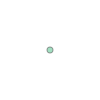

In [16]:
Point(Longitude, Latitude)

In [17]:
point_gdf = gpd.GeoDataFrame(data=['Charger'], geometry=[Point(Longitude, Latitude)])

In [18]:
point_gdf.loc[:, 'latitude'] = Latitude
point_gdf.loc[:, 'longitude'] = Longitude

In [19]:
import plotly.express as px
import base64
import plotly.graph_objects as go

token = open('../.mapbox_token').read()


fig_1 = px.scatter_mapbox(gdf, lat='latitude', lon='longitude',
                          color='distance',
                         color_continuous_scale='reds',
                          zoom=16, height=600)

# fig_1.add_trace(px.scatter_mapbox(point_gdf, lat='latitude', lon='longitude'))

fig_1.update_layout(mapbox_style="satellite",mapbox_accesstoken=token )

fig_1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig_1.update_traces(marker=dict(size=16))

NameError: name 'gdf' is not defined

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#flatten JSON, Normalize JSON to Dataframe
dataframe = json_normalize(items) 

# filter columns,consider only required columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
nearby = dataframe.loc[:, filtered_columns]

# filter the category for each row
nearby['venue.categories'] = nearby.apply(get_category_type, axis=1)

# clean columns
nearby.columns = [col.split('.')[-1] for col in nearby.columns]

#replce NaN values with Not found in address
nearby['address'] = nearby['address'].fillna("Not found")
nearby.head(10)      

In [ ]:
# creating map zoom at present Location
map = folium.Map(location=[latitude,longitude],zoom_start=14)

# adding the current location to map
folium.CircleMarker(location=[latitude,longitude],radius=5,color='red',fill=True,fill_color='red').add_to(map)
folium.Marker(location=[latitude,longitude],popup="<strong> Current Location</strong>",icon = folium.Icon(color='red')).add_to(map)

# drawing radius of search
folium.Circle(location=[latitude,longitude],radius=radius,color='blue',opacity=0.5,fill=True,fill_color='blue').add_to(map)

# adding all the popular places around
for lat,lon,name,cate,addr,dist in zip(nearby.lat,nearby.lng,nearby.name,nearby.categories,nearby.address,nearby.distance):
    folium.CircleMarker(location=[lat,lon],radius=5,color="red",fill=True,fill_color='red').add_to(map)
    folium.Marker(location=[lat,lon],
              popup= folium.Popup(('<strong><font color ="red">Name :     </font>'+name+'</strong><br>'+
                                   '<strong><font color ="red">Categorie :    </font>'+cate+'</strong><br>'+
                                   '<strong><font color ="red">Address :    </font>'+addr+'</strong><br>'+
                                   '<strong><font color ="red">Distance :    </font>'+str(dist)+' mts</strong>'
                                   ),max_width=250)).add_to(map)

map